Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [12]:
# Defining the path for train and test images
from pathlib import Path
## Todo: Update the paths of the train and test dataset

data_dir_train = "/content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train"
data_dir_test = "/content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Test"

In [13]:
os.listdir(data_dir_train)

['dermatofibroma',
 'seborrheic keratosis',
 'vascular lesion',
 'squamous cell carcinoma',
 'actinic keratosis',
 'basal cell carcinoma',
 'nevus',
 'pigmented benign keratosis',
 'melanoma']

In [14]:
os.listdir(data_dir_test)

['dermatofibroma',
 'seborrheic keratosis',
 'vascular lesion',
 'squamous cell carcinoma',
 'actinic keratosis',
 'basal cell carcinoma',
 'nevus',
 'pigmented benign keratosis',
 'melanoma']

In [15]:
import glob
image_count_train = len(glob.glob(data_dir_train + "/**/*.jpg"))
print(image_count_train)
#image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
#print(image_count_train)
image_count_test = len(glob.glob(data_dir_test + "/**/*.jpg"))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [16]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
!python --version

Python 3.10.12


In [9]:
!pip install tensorflow_datasets

In [17]:
from tensorflow.keras.utils import image_dataset_from_directory

Use 80% of the images for training, and 20% for validation.

In [18]:
# @title Training DataSet
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#train_ds = ##todo
#data_train =
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  validation_split=0.2,
  subset= 'training')



Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [19]:
# @title Visualize distribution of classes in the training dataset.
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,dermatofibroma,95
1,seborrheic keratosis,77
2,vascular lesion,139
3,squamous cell carcinoma,181
4,actinic keratosis,114
5,basal cell carcinoma,376
6,nevus,357
7,pigmented benign keratosis,462
8,melanoma,438


In [20]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds =  tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  validation_split=0.2,
  subset= 'validation'
)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [21]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

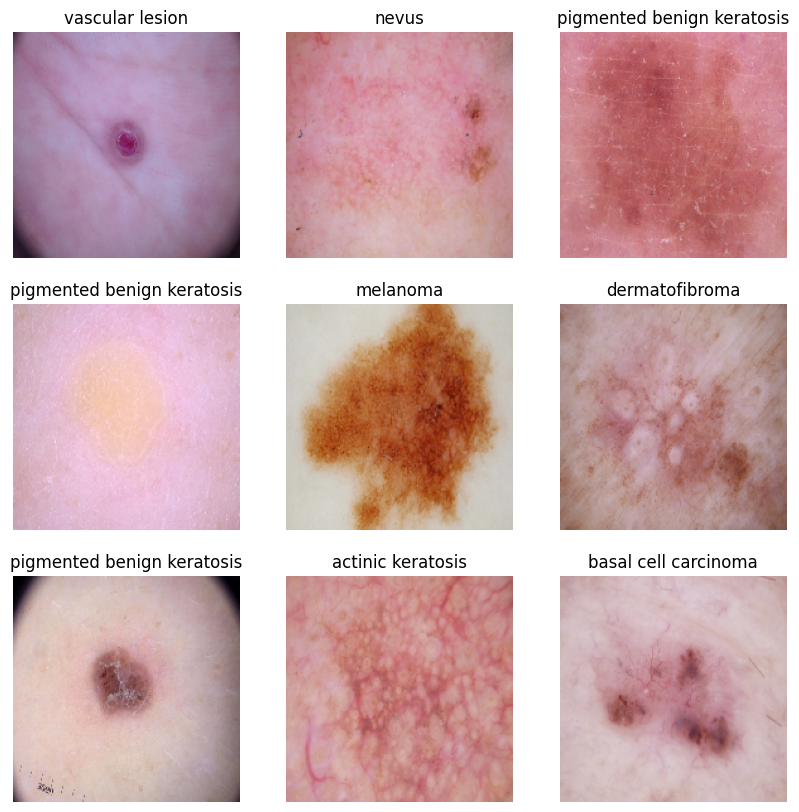

In [22]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [24]:
input_shape = (img_height,img_width,3)

model = Sequential()    #Sequential allows you to create models layer-by-layer

#First Convulation Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten())   #Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.



#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

In [25]:
len(class_names)


9

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [26]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

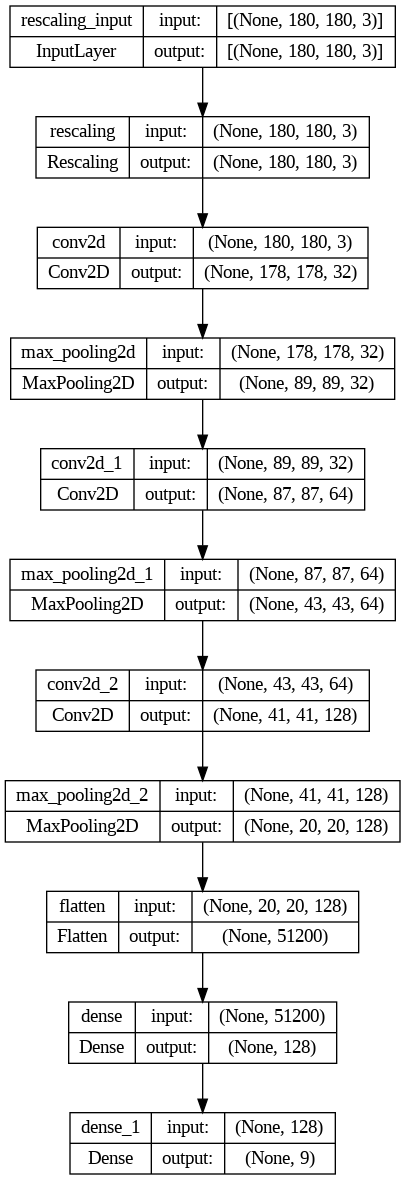

In [28]:
from tensorflow.keras.utils import plot_model
plot_model(model,to_file='model_plot.png',show_shapes=True, show_layer_names=True)

### Train the model

In [29]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 288s 1s/step - loss: 1.9082 - accuracy: 0.2840 - val_loss: 1.6537 - val_accuracy: 0.3870
Epoch 2/20
56/56 [==============================] - 2s 34ms/step - loss: 1.6569 - accuracy: 0.3934 - val_loss: 1.5972 - val_accuracy: 0.4362
Epoch 3/20
56/56 [==============================] - 2s 33ms/step - loss: 1.5495 - accuracy: 0.4570 - val_loss: 1.4644 - val_accuracy: 0.4787
Epoch 4/20
56/56 [==============================] - 2s 33ms/step - loss: 1.4025 - accuracy: 0.5028 - val_loss: 1.4471 - val_accuracy: 0.4877
Epoch 5/20
56/56 [==============================] - 2s 33ms/step - loss: 1.3085 - accuracy: 0.5324 - val_loss: 1.3764 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 2s 35ms/step - loss: 1.2454 - accuracy: 0.5564 - val_loss: 1.4827 - val_accuracy: 0.5034
Epoch 7/20
56/56 [==============================] - 2s 33ms/step - loss: 1.1608 - accuracy: 0.5882 - val_loss: 1.5743 - val_accuracy: 0.4564
Epoch 8/20
56/56 [======

### Visualizing training results

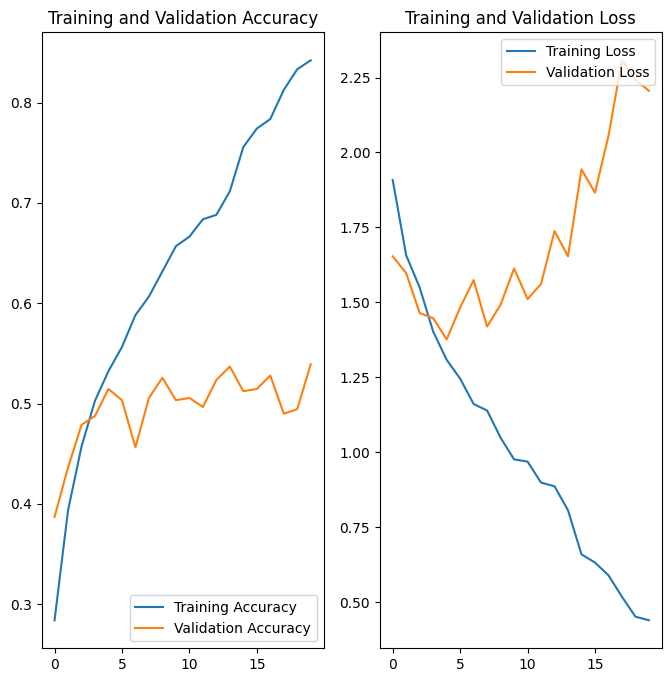

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [31]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
#As the training accuracy(92.35%)  is higher than validation accuracy(53.47%), it is an indication of overfitting. It means model is verfitting to the traing data.
# Your code goes here
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


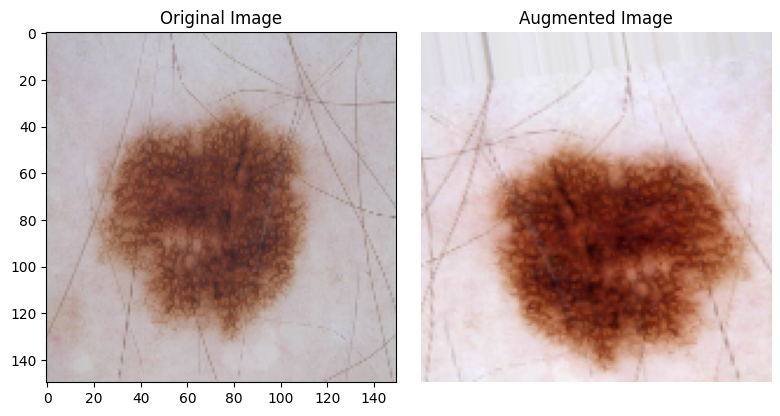

In [32]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
# Load a sample training image
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
img_path= "/content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/nevus/ISIC_0000019.jpg"
img = image.load_img(img_path, target_size=(150, 150))  # Adjust target size as needed
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')

# Apply augmentation transformations
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(1, 2, 2)
    plt.imshow(image.array_to_img(batch[0]))
    plt.title('Augmented Image')
    plt.axis('off')
    i += 1
    if i >= 1:  # Number of augmentation instances to generate
        break  # Break the loop to prevent infinite generation

plt.tight_layout()
plt.show()

### Todo:
### Create the model, compile and train the model


In [33]:
#Data augumentation strategy.
input_shape = (img_height,img_width,3)


data_augmentation = tf.keras.Sequential([
  #Randomly flip each image horizontally and vertically.
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),

  #Randomly rotate each image.
  layers.experimental.preprocessing.RandomRotation(0.2),

  #Randomly zoom each image during training.
  layers.experimental.preprocessing.RandomZoom(0.2),

  #Randomly contrast each image during training.
 layers.experimental.preprocessing.RandomTranslation(0.1,0.1)
])

In [34]:
input_shape = (img_height,img_width,3)

model2 = Sequential()                     #Sequential allows you to create models layer-by-layer

model2.add(data_augmentation)             #Augmentation layer

#First Convulation Layer
model2.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))
model2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))
#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Second Convulation Layer
model2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))
#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))


#Third Convulation Layer
model2.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))


model2.add(layers.Flatten())   #Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.

#Dense Layer
#model2.add(layers.Dense(512,activation='relu'))

#Dense Layer
model2.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model2.add(layers.Dropout(0.50))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model2.add(layers.Dense(len(class_names),activation='softmax'))

### Compiling the model

In [35]:
## Your code goes here
from tensorflow.keras.callbacks import ReduceLROnPlateau
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Use categorical crossentropy for multi-class classification
              optimizer=opt,
              metrics=['accuracy'],run_eagerly=True)

### Training the model

In [36]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model2.fit(train_ds,epochs=epochs,validation_data=val_ds)

Epoch 1/20


56/56 [==============================] - 12s 136ms/step - loss: 2.3916 - accuracy: 0.1741 - val_loss: 2.0791 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 7s 118ms/step - loss: 2.0478 - accuracy: 0.2042 - val_loss: 2.0858 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 7s 125ms/step - loss: 2.0023 - accuracy: 0.2277 - val_loss: 1.9930 - val_accuracy: 0.3378
Epoch 4/20
56/56 [==============================] - 6s 114ms/step - loss: 1.8870 - accuracy: 0.3019 - val_loss: 1.8274 - val_accuracy: 0.3468
Epoch 5/20
56/56 [==============================] - 7s 126ms/step - loss: 1.7287 - accuracy: 0.3811 - val_loss: 1.6753 - val_accuracy: 0.4564
Epoch 6/20
56/56 [==============================] - 7s 130ms/step - loss: 1.6256 - accuracy: 0.4146 - val_loss: 1.7154 - val_accuracy: 0.3781
Epoch 7/20
56/56 [==============================] - 6s 113ms/step - loss: 1.5929 - accuracy: 0.4347 - val_loss: 1.5568 - val_accuracy: 0.4586
Epoch 8/20
56/56

### Visualizing the results

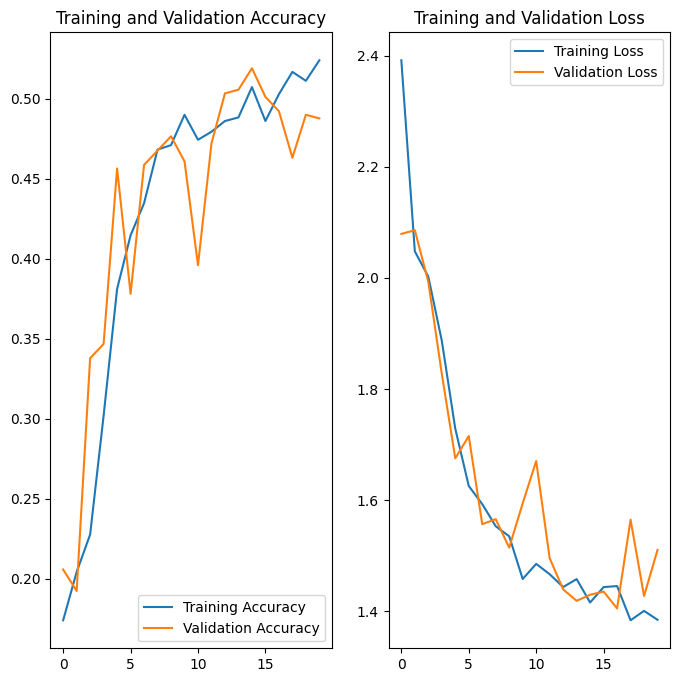

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 89, 89, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                      

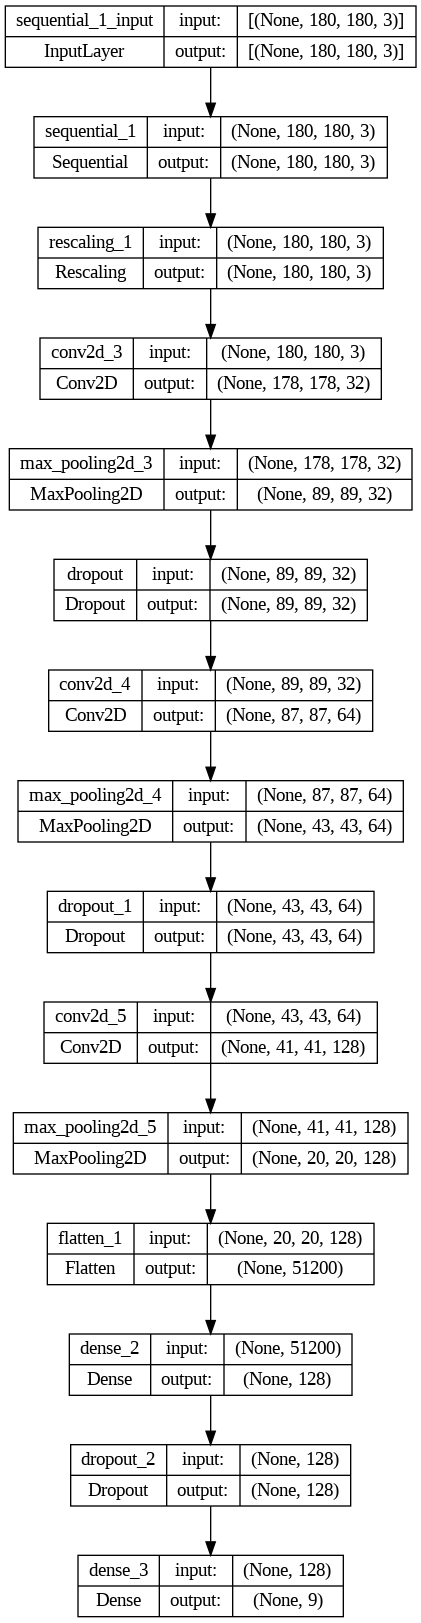

In [39]:
from tensorflow.keras.utils import plot_model
plot_model(model2,to_file='model2_plot.png',show_shapes=True, show_layer_names=True)

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [40]:
# @title Class Imbalance Detection
## Your code goes here.
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,dermatofibroma,95
1,seborrheic keratosis,77
2,vascular lesion,139
3,squamous cell carcinoma,181
4,actinic keratosis,114
5,basal cell carcinoma,376
6,nevus,357
7,pigmented benign keratosis,462
8,melanoma,438


**pigmented benign keratosis** has highest number of images while **seborrheic keratosis** has lowest no. of images. Image distribution is not uniform across classes, it indicating **Class Imbalance**.

<Axes: xlabel='No. of Image', ylabel='Class'>

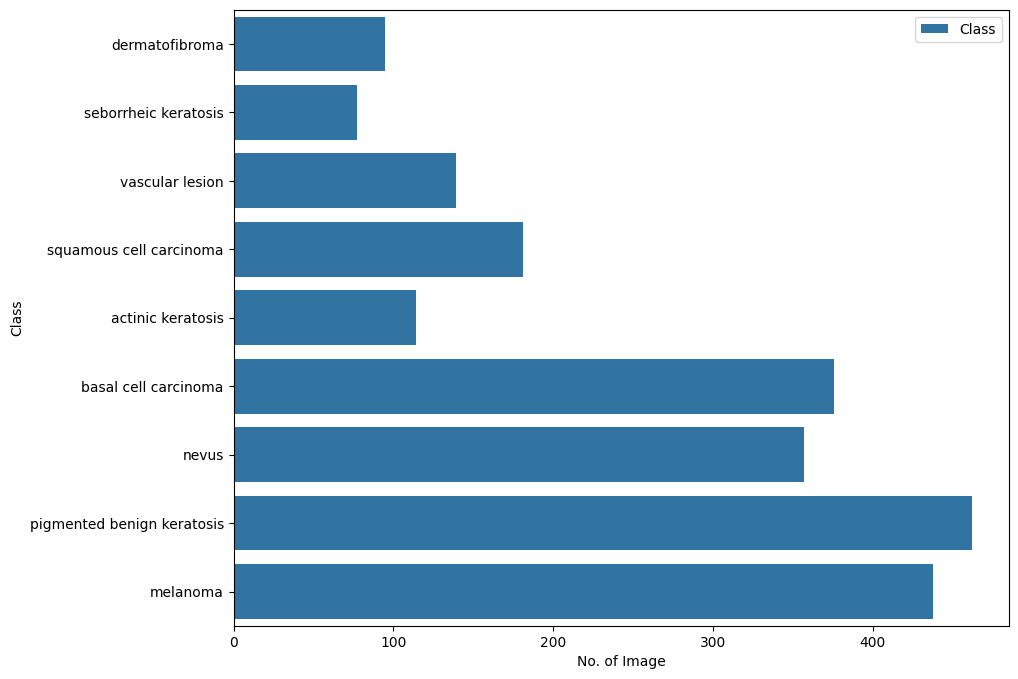

In [41]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
###- Seborrheic Keratosis has least number of samples.
#### - Which classes dominate the data in terms proportionate number of samples?
###- Pigmented benign keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To rectify class imbalance, we will use Augmentor and add 500 samples across all classes.

In [42]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [43]:
path_to_training_dataset="/content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D90AC5FC460>: 100%|██████████| 500/500 [00:30<00:00, 16.37 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D90AC624EE0>: 100%|██████████| 500/500 [00:27<00:00, 18.47 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D90BE77F250>: 100%|██████████| 500/500 [00:19<00:00, 25.36 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D90AC5FC550>: 100%|██████████| 500/500 [01:45<00:00,  4.73 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7D90AC51B7C0>: 100%|██████████| 500/500 [01:31<00:00,  5.47 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D90AC58BB80>: 100%|██████████| 500/500 [00:22<00:00, 22.12 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7D90AC5F71F0>: 100%|██████████| 500/500 [00:43<00:00, 11.49 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D90AC6E2350>: 100%|██████████| 500/500 [00:20<00:00, 24.17 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D90AC6C42B0>: 100%|██████████| 500/500 [00:22<00:00, 22.07 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [44]:
import glob
image_count_train = len(glob.glob(data_dir_train + "/**/output/*.jpg"))
print(image_count_train)
#image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
#print(image_count_train)

0




There are 4500 images in output directory



### Lets see the distribution of augmented data after adding new images to the original training data.

In [45]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '**','output', '*.jpg'))]
path_list

[]

In [46]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '**','output', '*.jpg'))]
lesion_list_new

[]

In [47]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [48]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [49]:
new_df=df2

In [50]:
new_df['Label'].value_counts()

Series([], Name: count, dtype: int64)

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [52]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [53]:
data_dir_train="/content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
validation_split = 0.2,
subset = "training",  # Choose the correct parameter value to refer only to training data
image_size =(img_height, img_width),
#label_mode='categorical',
batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [54]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  #label_mode='categorical',
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [55]:
## your code goes here
#Model

model3 = Sequential()
model3.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))
#First Convulation layer
model3.add(layers.Conv2D(32,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Second Convulation Layer
model3.add(layers.Conv2D(64,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Third Convulation Layer
model3.add(layers.Conv2D(128,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
model3.add(layers.Flatten())

#Dense Layer
model3.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model3.add(layers.Dropout(0.50))
#Dense layer with Softmax activation function.
model3.add(layers.Dense(len(class_names),activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [56]:
opt=tf.keras.optimizers.Adam()
model3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # Use categorical crossentropy for multi-class classification
              optimizer=opt,
              metrics=['accuracy'],run_eagerly=True)

In [57]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 179, 179, 32)      416       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 89, 89, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 88, 88, 64)        8256      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 44, 44, 64)        0         
 g2D)                                                 

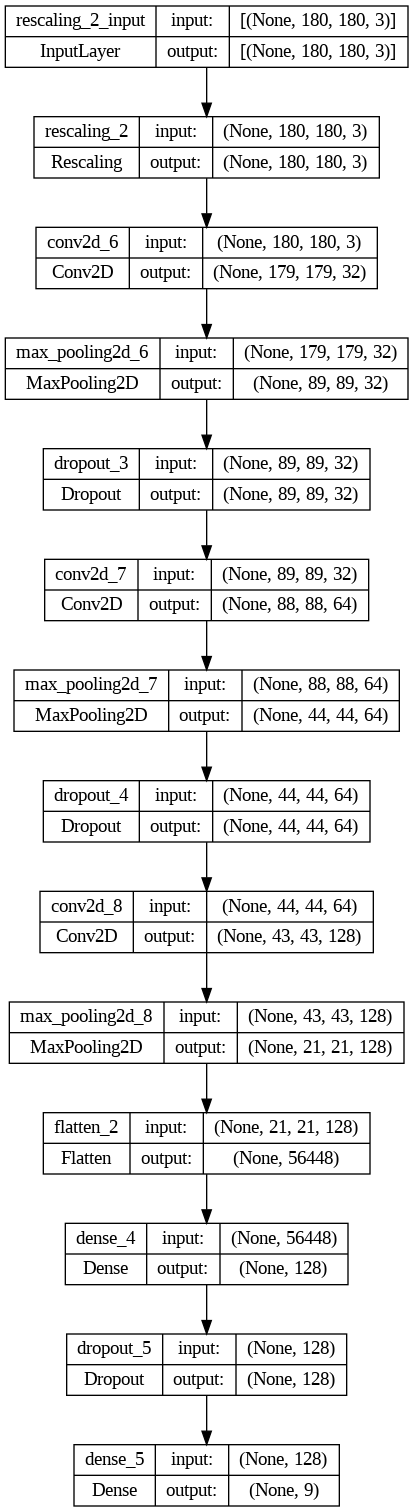

In [58]:
from tensorflow.keras.utils import plot_model
plot_model(model3,to_file='model3_plot.png',show_shapes=True, show_layer_names=True)

#### **Todo:**  Train your model

In [59]:

epochs = 30
#labels = tf.reshape(labels, (-1, 1))
## Your code goes here, use 30 epochs.
history = model3.fit(train_ds,epochs=epochs,validation_data=val_ds)

Epoch 1/30
169/169 [==============================] - 58s 289ms/step - loss: 2.1089 - accuracy: 0.2125 - val_loss: 1.8541 - val_accuracy: 0.3274
Epoch 2/30
169/169 [==============================] - 50s 287ms/step - loss: 1.7131 - accuracy: 0.3444 - val_loss: 1.5457 - val_accuracy: 0.4306
Epoch 3/30
169/169 [==============================] - 48s 277ms/step - loss: 1.5660 - accuracy: 0.3967 - val_loss: 1.4969 - val_accuracy: 0.4521
Epoch 4/30
169/169 [==============================] - 49s 283ms/step - loss: 1.4978 - accuracy: 0.4201 - val_loss: 1.4129 - val_accuracy: 0.4603
Epoch 5/30
169/169 [==============================] - 49s 277ms/step - loss: 1.4406 - accuracy: 0.4330 - val_loss: 1.3670 - val_accuracy: 0.4432
Epoch 6/30
169/169 [==============================] - 48s 278ms/step - loss: 1.3625 - accuracy: 0.4722 - val_loss: 1.3846 - val_accuracy: 0.4506
Epoch 7/30
169/169 [==============================] - 47s 273ms/step - loss: 1.3749 - accuracy: 0.4625 - val_loss: 1.1876 - val_ac

#### **Todo:**  Visualize the model results

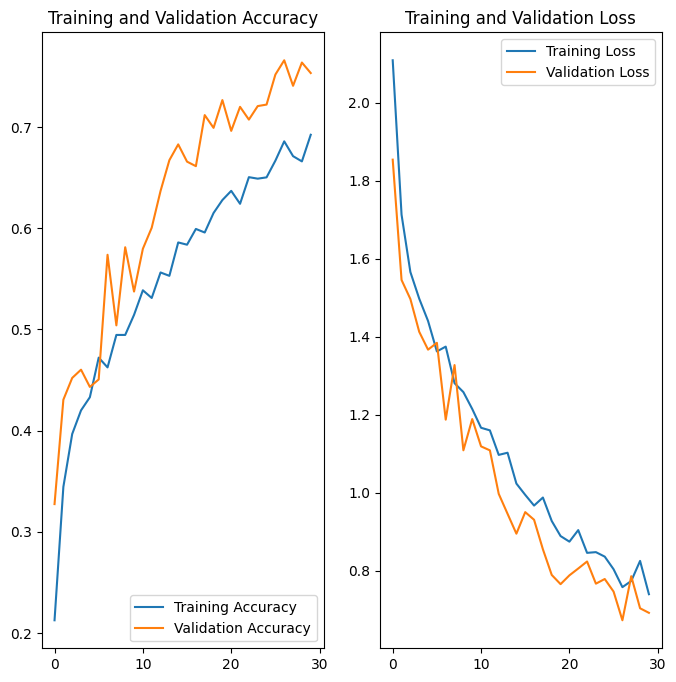

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
Yes, overfitting is resolved, but validation accuracy is quite following training accuracy. Model is trained with dropout layers placed after 1st &  2nd Convolution layer and dense layer.





### To get better results, we add one more droput layer after 3rd convolution layer.

In [61]:
## your code goes here
#Model

model3 = Sequential()


model3.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))
#First Convulation layer
model3.add(layers.Conv2D(32,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Second Convulation Layer
model3.add(layers.Conv2D(64,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Third Convulation Layer
model3.add(layers.Conv2D(128,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.250))
#Flatten Layer
model3.add(layers.Flatten())

#Batch normalization: is a method used to make artificial neural networks faster and more stable through normalization
#of the layers' inputs by re-centering and re-scaling.
#model3.add(layers.BatchNormalization())

#Dense Layer
model3.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model3.add(layers.Dropout(0.50))



#Dense layer with Softmax activation function.
model3.add(layers.Dense(len(class_names),activation='softmax'))

In [62]:
opt=tf.keras.optimizers.Adam()
model3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # Use categorical crossentropy for multi-class classification
              optimizer=opt,
              metrics=['accuracy'],run_eagerly=True)

In [63]:
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 179, 179, 32)      416       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 89, 89, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 88, 88, 64)        8256      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 44, 44, 64)        0         
 ng2D)                                                

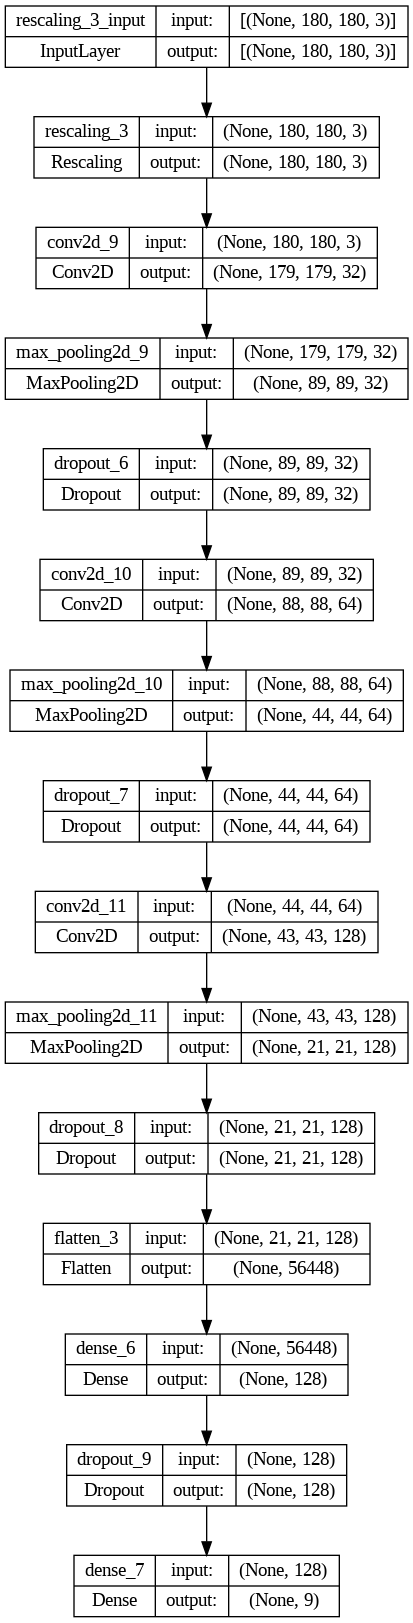

In [64]:
from tensorflow.keras.utils import plot_model
plot_model(model3,to_file='model3_plot.png',show_shapes=True, show_layer_names=True)

In [65]:

epochs = 30
#labels = tf.reshape(labels, (-1, 1))
## Your code goes here, use 30 epochs.
history = model3.fit(train_ds,epochs=epochs,validation_data=val_ds)

Epoch 1/30
169/169 [==============================] - 49s 273ms/step - loss: 2.1144 - accuracy: 0.2088 - val_loss: 1.7991 - val_accuracy: 0.3274
Epoch 2/30
169/169 [==============================] - 48s 277ms/step - loss: 1.7695 - accuracy: 0.2969 - val_loss: 1.7425 - val_accuracy: 0.3705
Epoch 3/30
169/169 [==============================] - 50s 281ms/step - loss: 1.5765 - accuracy: 0.4021 - val_loss: 1.4847 - val_accuracy: 0.4788
Epoch 4/30
169/169 [==============================] - 48s 277ms/step - loss: 1.4658 - accuracy: 0.4473 - val_loss: 1.3656 - val_accuracy: 0.4974
Epoch 5/30
169/169 [==============================] - 48s 274ms/step - loss: 1.3656 - accuracy: 0.4761 - val_loss: 1.3489 - val_accuracy: 0.5256
Epoch 6/30
169/169 [==============================] - 48s 275ms/step - loss: 1.2890 - accuracy: 0.4981 - val_loss: 1.2887 - val_accuracy: 0.5509
Epoch 7/30
169/169 [==============================] - 50s 283ms/step - loss: 1.2665 - accuracy: 0.5171 - val_loss: 1.1927 - val_ac

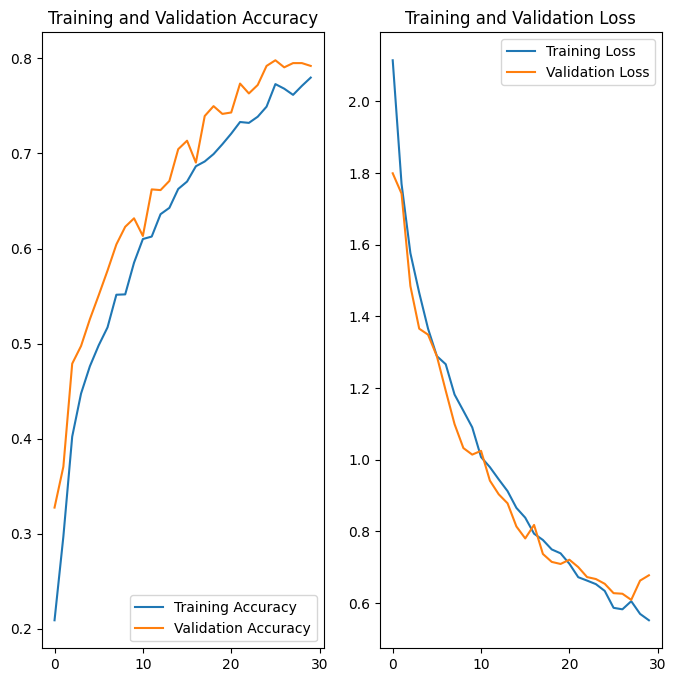

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Better training accuracy than last model.

## Now, we will increase model complexity,  by adding one convolution layer and dense layer.

In [67]:
## your code goes here
#Model
input_shape = (img_height,img_width,3)
model3 = Sequential()
model3.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))
#First Convulation layer
model3.add(layers.Conv2D(32,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
#Second Convulation Layer
model3.add(layers.Conv2D(64,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
#Third Convulation Layer
model3.add(layers.Conv2D(128,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
#Fourth  Convulation Layer
model3.add(layers.Conv2D(256,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout Layer
model3.add(layers.Dropout(0.50))

#Flatten Layer
model3.add(layers.Flatten())

#Dense Layer
model3.add(layers.Dense(256,activation='relu'))
#Dropout Layer
model3.add(layers.Dropout(0.250))

#Dense Layer
model3.add(layers.Dense(128,activation='relu'))
#Dropout layer with 25% Fraction of the input units to drop.
model3.add(layers.Dropout(0.250))

model3.add(layers.Dense(64,activation='relu'))
model3.add(layers.Dropout(0.25))

#Dense layer with Softmax activation function.
model3.add(layers.Dense(9,activation='softmax'))

In [68]:
opt=tf.keras.optimizers.Adam()
model3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # Use categorical crossentropy for multi-class classification
              optimizer=opt,
              metrics=['accuracy'],run_eagerly=True)

In [69]:
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 179, 179, 32)      416       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 88, 88, 64)        8256      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 44, 44, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 43, 43, 128)      

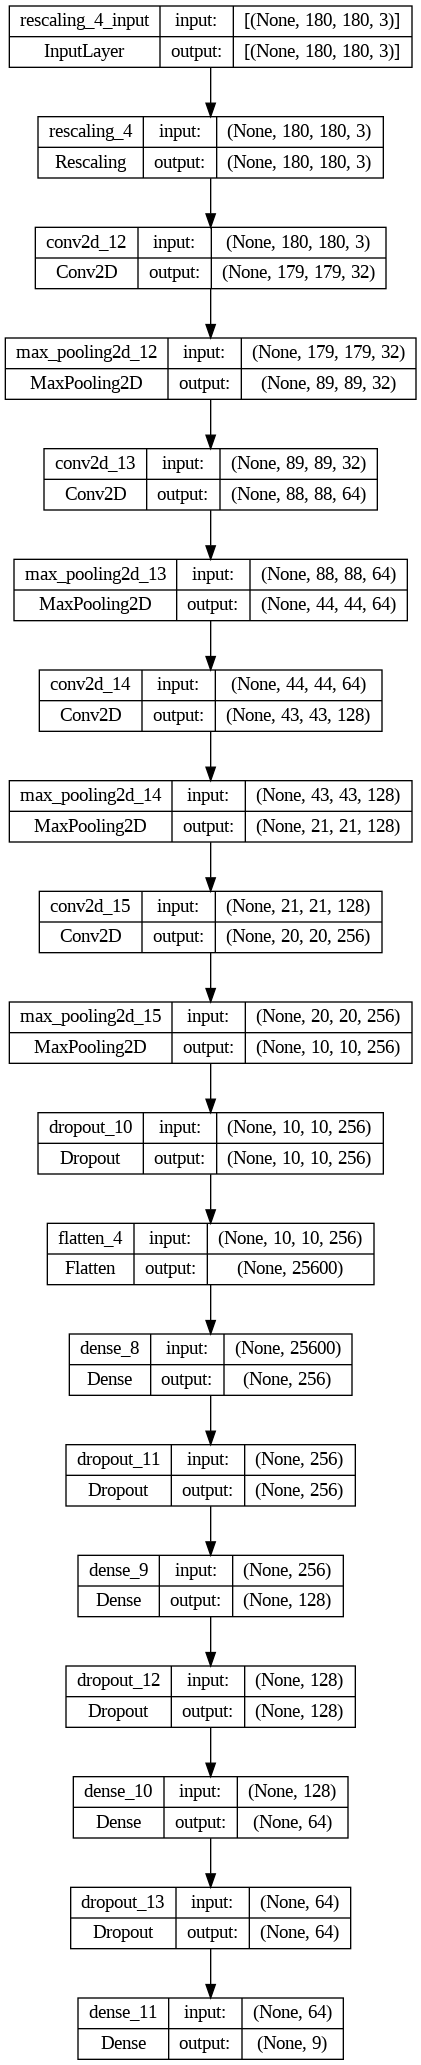

In [70]:
from tensorflow.keras.utils import plot_model
plot_model(model3,to_file='model3_plot.png',show_shapes=True, show_layer_names=True)

In [71]:

epochs = 30
#labels = tf.reshape(labels, (-1, 1))
## Your code goes here, use 30 epochs.
history = model3.fit(train_ds,epochs=epochs,validation_data=val_ds)

Epoch 1/30
169/169 [==============================] - 53s 284ms/step - loss: 2.0430 - accuracy: 0.1927 - val_loss: 1.8236 - val_accuracy: 0.2829
Epoch 2/30
169/169 [==============================] - 49s 281ms/step - loss: 1.7556 - accuracy: 0.2978 - val_loss: 1.5719 - val_accuracy: 0.3950
Epoch 3/30
169/169 [==============================] - 50s 287ms/step - loss: 1.5720 - accuracy: 0.3750 - val_loss: 1.4410 - val_accuracy: 0.4298
Epoch 4/30
169/169 [==============================] - 49s 281ms/step - loss: 1.4961 - accuracy: 0.4151 - val_loss: 1.3386 - val_accuracy: 0.4699
Epoch 5/30
169/169 [==============================] - 51s 294ms/step - loss: 1.4562 - accuracy: 0.4323 - val_loss: 1.2927 - val_accuracy: 0.4729
Epoch 6/30
169/169 [==============================] - 49s 280ms/step - loss: 1.3453 - accuracy: 0.4703 - val_loss: 1.2791 - val_accuracy: 0.4974
Epoch 7/30
169/169 [==============================] - 48s 276ms/step - loss: 1.2561 - accuracy: 0.5124 - val_loss: 1.1383 - val_ac

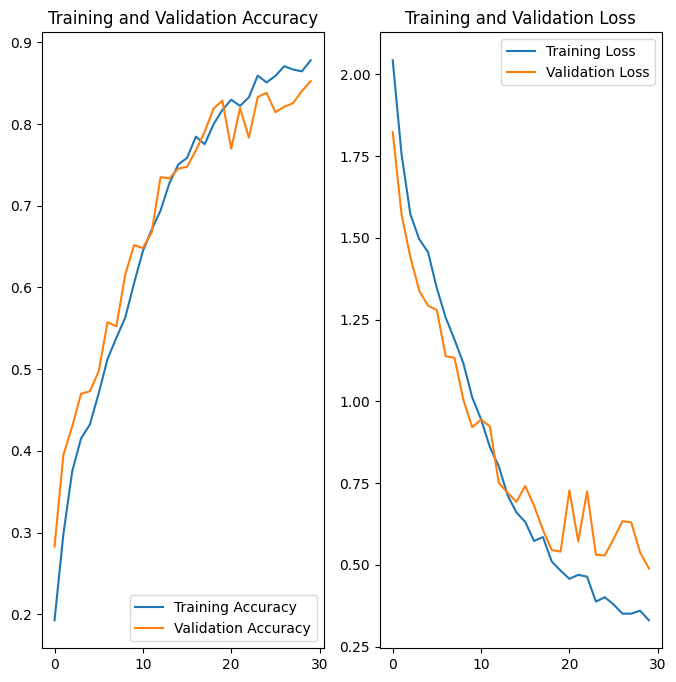

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## We get rid of overfitting, Validation accuracy is following tarining accuracy.